In [1]:
import os
import sys
import pickle
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, f1_score, accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import pyarrow.parquet as pq
import oss2
import io


In [ ]:
full_data = pd.read_pickle('z_data_new2/data_merged101/07_12_merged_101.pkl')
model_file = "z_model/model_data/22_28_model_20250115_11:20.pkl"
# full_data = full_data.drop('Unnamed: 0',axis= 1)
# train_data, full_data = train_test_split(full_data, test_size=0.2, random_state=42)


full_data = full_data[(full_data['lable_x'] != 0) | (full_data['weekly_order_cnt'] < 4)]
drop_column = ['annual_voljson_raw_max', 'annual_voljson_raw_min', 'annual_voljson_raw_count', 'annual_voljson_max_', 'annual_voljson_mean_', 'annual_voljson_mid_', 'annual_voljson_min_', 'annual_voljson_count_', 'pricejson_raw_max', 'pricejson_raw_min', 'pricejson_raw_count', 'pricejson_max_', 'pricejson_mean_', 'pricejson_mid_', 'pricejson_min_', 'pricejson_count_', 'pricejson_update_time', 'discountjson_raw_max', 'discountjson_raw_min', 'discountjson_raw_count', 'discountjson_max_', 'discountjson_mean_', 'discountjson_mid_', 'discountjson_min_', 'p_diffjson_raw_max', 'p_diffjson_raw_min', 'p_diffjson_raw_count', 'p_diffjson_max_', 'p_diffjson_mean_', 'p_diffjson_mid_', 'p_diffjson_min_', 'p_diffjson_count_']
full_data.drop(columns=drop_column,inplace=True)


In [3]:
black_list = pd.read_csv('black_categories.csv')
# 删除 full_data 中在 black_list 中的行
filtered_data = full_data[~full_data[['category_name', 'level_one_category_name']].apply(tuple, axis=1).isin(black_list['category_name'])]


In [4]:
encoder_path = 'z_model/encoder_data'
model_path = 'z_model/model_data'
print(encoder_path)
print(model_path)

z_model/encoder_data
z_model/model_data


### 对原始数据整数编码

In [5]:
label_encoder_level_one_category_name = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_level_one_category_name.pkl"), "rb"))
label_encoder_category_name = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_category_name.pkl"), "rb"))
label_encoder_category_category_first = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_category_first.pkl"), "rb"))
label_encoder_category_category_second = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_category_second.pkl"), "rb"))
label_encoder_category_audience = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_audience.pkl"), "rb"))
label_encoder_category_scenario = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_scenario.pkl"), "rb"))


label_encoder_brand_name = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_brand_name.pkl"), "rb"))
label_encoder_shop_title = pickle.load(open(os.path.join(encoder_path, "22_28_llabel_encoder_shop_title.pkl"), "rb"))
label_encoder_feature1 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature1.pkl"), "rb"))
label_encoder_feature2 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature2.pkl"), "rb"))
label_encoder_feature3 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature3.pkl"), "rb"))
label_encoder_feature4 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature4.pkl"), "rb"))
label_encoder_feature5 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature5.pkl"), "rb"))
label_encoder_feature6 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_feature6.pkl"), "rb"))
label_encoder_scenario_1 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_scenario_1.pkl"), "rb"))
label_encoder_scenario_2 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_scenario_2.pkl"), "rb"))
label_encoder_brand_real_1 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_brand_real_1.pkl"), "rb"))
label_encoder_brand_real_2 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_brand_real_2.pkl"), "rb"))
label_encoder_audience_1 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_audience_1.pkl"), "rb"))
label_encoder_audience_2 = pickle.load(open(os.path.join(encoder_path, "22_28_label_encoder_audience_2.pkl"), "rb"))

  
# label_encoder_p = pickle.load(open(os.path.join(encoder_path, "label_encoder2_p.pkl"), "rb"))
print("2")

2


In [ ]:
columns = full_data.columns
for col in columns:
    print(f"列名: {col}, 不同值的数量: {full_data[col].nunique()}")


列名: title_x, 不同值的数量: 554306
列名: buy_num_x, 不同值的数量: 247
列名: click_num_x, 不同值的数量: 469
列名: brand_name, 不同值的数量: 93268
列名: category_name, 不同值的数量: 9886
列名: commission_amount, 不同值的数量: 15271
列名: final_promotion_price, 不同值的数量: 38027
列名: income_rate, 不同值的数量: 1407
列名: level_one_category_name, 不同值的数量: 138
列名: reserve_price, 不同值的数量: 27802
列名: shop_title, 不同值的数量: 187317
列名: user_type, 不同值的数量: 2
列名: volume, 不同值的数量: 137
列名: zk_final_price, 不同值的数量: 30657
列名: monthly_browse_ratio, 不同值的数量: 326409
列名: monthly_click_ratio, 不同值的数量: 10750
列名: monthly_order_ratio, 不同值的数量: 6107
列名: weekly_browse_ratio, 不同值的数量: 229011
列名: weekly_click_ratio, 不同值的数量: 3736
列名: weekly_order_ratio, 不同值的数量: 5372
列名: daily_browse_ratio, 不同值的数量: 108415
列名: daily_click_ratio, 不同值的数量: 1307
列名: daily_order_ratio, 不同值的数量: 2695
列名: monthly_browse_cnt, 不同值的数量: 42747
列名: monthly_click_cnt, 不同值的数量: 1020
列名: monthly_order_cnt, 不同值的数量: 974
列名: weekly_browser_cnt, 不同值的数量: 21297
列名: weekly_click_cnt, 不同值的数量: 479
列名: weekly_order_cnt, 不同值的数量: 717


In [7]:
# 在进行转换前，先处理缺失值
full_data["level_one_category_name"] = full_data["level_one_category_name"].fillna('Unknown')
full_data["category_name"] = full_data["category_name"].fillna('Unknown')
full_data["category_first"] = full_data["category_first"].fillna('Unknown')
full_data["category_second"] = full_data["category_second"].fillna('Unknown')
# full_data["audience"] = full_data["audience"].fillna('Unknown')
# full_data["scenario"] = full_data["scenario"].fillna('Unknown')

full_data["brand_name"] = full_data["brand_name"].fillna('Unknown')
full_data["shop_title"] = full_data["shop_title"].fillna('Unknown')
full_data["feature1"] = full_data["feature1"].fillna('Unknown')
full_data["feature2"] = full_data["feature2"].fillna('Unknown')
full_data["feature3"] = full_data["feature3"].fillna('Unknown')
full_data["feature4"] = full_data["feature4"].fillna('Unknown')
full_data["feature5"] = full_data["feature5"].fillna('Unknown')
full_data["feature6"] = full_data["feature6"].fillna('Unknown')
full_data["scenario_1"] = full_data["scenario_1"].fillna('Unknown')
full_data["scenario_2"] = full_data["scenario_2"].fillna('Unknown')
full_data["brand_real_1"] = full_data["brand_real_1"].fillna('Unknown')
full_data["brand_real_2"] = full_data["brand_real_2"].fillna('Unknown')
full_data["audience_1"] = full_data["audience_1"].fillna('Unknown')
full_data["audience_2"] = full_data["audience_2"].fillna('Unknown')



In [8]:
full_data["level_one_category_name"] = label_encoder_level_one_category_name.transform(full_data["level_one_category_name"].to_numpy().reshape(-1, 1))
full_data["category_name"] = label_encoder_category_name.transform(full_data["category_name"].to_numpy().reshape(-1, 1))
full_data["category_first"] = label_encoder_level_one_category_name.transform(full_data["category_first"].to_numpy().reshape(-1, 1))
full_data["category_second"] = label_encoder_category_name.transform(full_data["category_second"].to_numpy().reshape(-1, 1))
# full_data["audience"] = label_encoder_level_one_category_name.transform(full_data["audience"].to_numpy().reshape(-1, 1))
# full_data["scenario"] = label_encoder_category_name.transform(full_data["scenario"].to_numpy().reshape(-1, 1))

full_data["brand_name"] = label_encoder_brand_name.transform(full_data["brand_name"].to_numpy().reshape(-1, 1))
full_data["shop_title"] = label_encoder_shop_title.transform(full_data["shop_title"].to_numpy().reshape(-1, 1))
full_data["feature1"] = label_encoder_feature1.transform(full_data["feature1"].to_numpy().reshape(-1, 1))
full_data["feature2"] = label_encoder_feature2.transform(full_data["feature2"].to_numpy().reshape(-1, 1))
full_data["feature3"] = label_encoder_feature3.transform(full_data["feature3"].to_numpy().reshape(-1, 1))
full_data["feature4"] = label_encoder_feature4.transform(full_data["feature4"].to_numpy().reshape(-1, 1))
full_data["feature5"] = label_encoder_feature5.transform(full_data["feature5"].to_numpy().reshape(-1, 1))
full_data["feature6"] = label_encoder_feature6.transform(full_data["feature6"].to_numpy().reshape(-1, 1))
full_data["scenario_1"] = label_encoder_scenario_1.transform(full_data["scenario_1"].to_numpy().reshape(-1, 1))
full_data["scenario_2"] = label_encoder_scenario_2.transform(full_data["scenario_2"].to_numpy().reshape(-1, 1))
full_data["brand_real_1"] = label_encoder_brand_real_1.transform(full_data["brand_real_1"].to_numpy().reshape(-1, 1))
full_data["brand_real_2"] = label_encoder_brand_real_2.transform(full_data["brand_real_2"].to_numpy().reshape(-1, 1))
full_data["audience_1"] = label_encoder_audience_1.transform(full_data["audience_1"].to_numpy().reshape(-1, 1))
full_data["audience_2"] = label_encoder_audience_2.transform(full_data["audience_2"].to_numpy().reshape(-1, 1))





print(f"全部的训练数据正负例分布: {full_data['lable_x'].value_counts()}")
Train_data = full_data#.loc[train_data.apply(lambda x: x["push_num"] > x["click_num"] and x["click_num"] > 0, axis=1)]
# print(f"全部的训练数据正负例分布: {Train_data['status'].value_counts()}")

target = Train_data['lable_x']
# 将数据集划分为训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(Train_data, target, test_size=0.2, random_state=42)
# # 进一步划分验证集（可选）
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# test_data["level_one_category_name"] = label_encoder_level_one_category_name.transform(test_data["level_one_category_name"].to_numpy().reshape(-1,1))
# test_data["category_name"] = label_encoder_category_name.transform(test_data["category_name"].to_numpy().reshape(-1,1))
# Test_data = test_data#.loc[test_data.apply(lambda x: x["push_num"] > x["click_num"] and x["click_num"] > 0, axis=1)]
# print(f"全部的额外测试数据正负例分布: {Test_data['lable_x'].value_counts()}")


# # train,test,val分别是训练 测试 验证集
# print("__________________")
# print(f"额外的训练数据正负例分布: {Train_data['lable_x'].value_counts()}")
# # print(f"额外的测试数据正负例分布: {X_test['lable_x'].value_counts()}")
# print(f"额外的验证数据正负例分布: {X_val['lable_x'].value_counts()}")

# print(f"训练集大小: {X_train.shape}")
# print(f"验证集大小: {X_val.shape}")
# print(f"测试集大小: {X_test.shape}")
# print(f"额外的测试数据大小: {Test_data.shape}")

# print(f"额外的测试数据正负例分布: {Test_data['status'].value_counts()}")

全部的训练数据正负例分布: lable_x
0.0    466122
1.0    202980
Name: count, dtype: int64


In [9]:
tmp_drop_columns = ['title_x','pricejson_update_time','lable_x','click_num_x','buy_num_x','feature','obj_scenario','time_scenario','dep_scenario','subj_scenario','brand_quality','brand_real','category'
    ] + [
        # x for x in train_data.columns if x.endswith("species_in_history") or x.endswith("count_in_history")
    ] + [
    # "portrait_count",
    # "portrait_weight"
   ] + [
    #    x for x in X_train.columns if "history_valid" in x or "by_history" in x or "over_median" in x or "in_history" in x or "in_last_day" in x
    # x for x in X_train.columns if "value" in x or x.endswith("price") or x == "discount" or x == "discount_rate" or x == "volume"
   ] + [
    #    x for x in X_train.columns if "7d_sum" in x
   ]
tmp_drop_columns

['title_x',
 'pricejson_update_time',
 'lable_x',
 'click_num_x',
 'buy_num_x',
 'feature',
 'obj_scenario',
 'time_scenario',
 'dep_scenario',
 'subj_scenario',
 'brand_quality',
 'brand_real',
 'category']

In [10]:
data_view = Train_data.drop(columns=[col for col in tmp_drop_columns if col in Train_data.columns])

### 模型读取与训练

[0.07314035 0.32575124 0.28994607 ... 0.36035191 0.65100767 0.3356659 ]


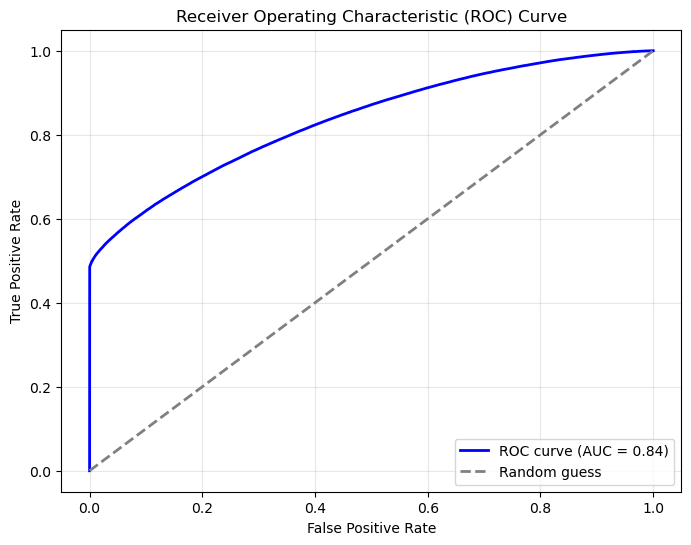

In [ ]:
import pickle
import pandas as pd


with open(f"{model_file}", "rb") as file:
    lgb_model = pickle.load(file)

if any(col in Train_data.columns for col in tmp_drop_columns):
    Train_data = Train_data.drop(columns=[col for col in tmp_drop_columns if col in Train_data.columns])


train_columns = lgb_model.feature_name()  
new_data = Train_data[train_columns]  # 重新排序列



predictions = lgb_model.predict(new_data)


print(predictions)


fpr, tpr, thresholds = roc_curve(target, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [12]:
# 假设y_true是真实的标签，y_pred是模型的预测标签
for thred in [0.05,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]:
    print(f"==============================thred={thred}==================================")
    print(classification_report(target, (predictions > thred).astype(int), target_names=['负例', '正例'], digits=4))




==============================thred=0.05==================================
              precision    recall  f1-score   support

          负例     0.9771    0.0222    0.0434    466122
          正例     0.3079    0.9988    0.4707    202980

    accuracy                         0.3184    669102
   macro avg     0.6425    0.5105    0.2570    669102
weighted avg     0.7741    0.3184    0.1730    669102

==============================thred=0.1==================================
              precision    recall  f1-score   support

          负例     0.9630    0.0770    0.1425    466122
          正例     0.3191    0.9932    0.4830    202980

    accuracy                         0.3549    669102
   macro avg     0.6410    0.5351    0.3128    669102
weighted avg     0.7676    0.3549    0.2458    669102

==============================thred=0.2==================================
              precision    recall  f1-score   support

          负例     0.9337    0.2483    0.3922    466122
          正例  

In [14]:
# print(sum(predictions>0.7))
# print(sum(predictions>0.8))

In [ ]:
# def precision_for_positive_class(y_true, y_pred_prob, threshold=0.5):

#     y_pred = (y_pred_prob > threshold).astype(int)
    
#     y_true = np.array(y_true)
    
#     # 计算 True Positive 和 False Positive
#     tp = np.sum((y_true == 1) & (y_pred == 1))  
#     fp = np.sum((y_true == 0) & (y_pred == 1)) 
    
#     if tp + fp == 0:
#         return 0.0 
#     precision = tp / (tp + fp)
    
#     print(f'阈值：{threshold},precision：{precision},tp:{tp},fp:{fp}') 

In [16]:
# for thred in [0.05, 0.1, 0.35,0.4,0.45,0.5,0.6, 0.65, 0.7,0.75, 0.8, 0.85, 0.9, 0.95]:
#     precision_for_positive_class(target,predictions,thred)

In [17]:
# 将 predictions 和 target 合并成一个 DataFrame
P_T = pd.DataFrame({
    'Predictions': predictions,
    'Target': target
})


TT = P_T[P_T['Target' ]== 1]
TF = P_T[P_T['Target' ]== 0]

TT = TT['Predictions']
TF = TF['Predictions']

/tmp/ipykernel_2828210/665268566.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(TT, shade=True, color="b", label='T')
/tmp/ipykernel_2828210/665268566.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(TF, shade=True, color="r", label='F')


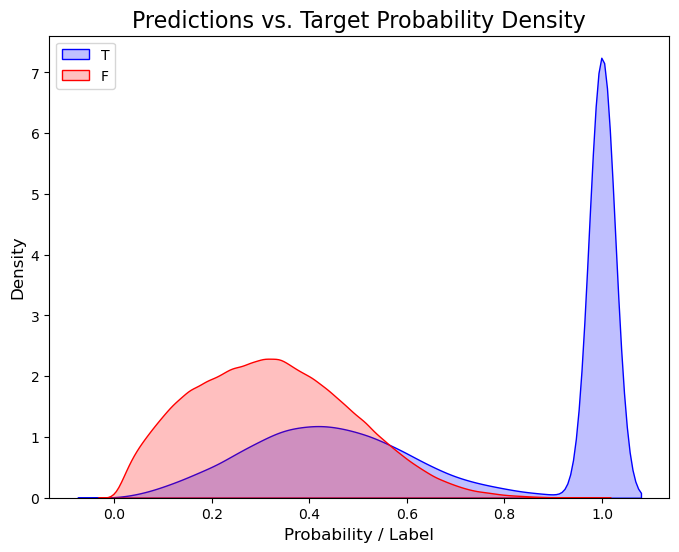

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.figure(figsize=(8, 6))
sns.kdeplot(TT, shade=True, color="b", label='T')
sns.kdeplot(TF, shade=True, color="r", label='F')
plt.title("Predictions vs. Target Probability Density", fontsize=16)
plt.xlabel("Probability / Label", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.show()
